In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from pandas.core.common import random_state
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import pandas as pd
import numpy as np


In [ ]:
#device = torch.device("cuda:0")

In [ ]:
path = '/content/drive/MyDrive/writer/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test_x.csv')
sub = pd.read_csv(path+ 'sample_submission.csv')

In [ ]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [ ]:
sub.head()

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0


In [ ]:
au = train.author.values

In [ ]:
au

array([3, 2, 1, ..., 1, 3, 0])

In [ ]:
train.text.values

array(['He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.',
       '“Your sister asked for it, I suppose?”',
       ' She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by Mr. odin, she saw on looking up that odin was meeting her. Putting away the letter immediately and forcing a smile, she said:',
       ..., ' "Your sincere well-wisher, friend, and sister, "LUCY odin.',
       '“Then you wanted me to lend you money?”',
       'It certainly had not occurred to me before, but I said, Yes, I should like that.'],
      dtype=object)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train.text.values, au, stratify=au,random_state = 42, test_size = 0.2, shuffle=True)

In [ ]:
np.random.seed(42)
au = to_categorical(au)
au

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
#preprocess
def preprocess(text):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    prods = set(text) & signs
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    return text

In [ ]:
x_train[1]

'The sound of his feet upon the causeway began the business of the day; for the village was still sound asleep. The church tower looked very airy in the sunlight; a few birds that turned about it, seemed to swim in an atmosphere of more than usual rarity; and the Doctor, walking in long transparent shadows, filled his lungs amply, and proclaimed himself well contented with the morning.'

In [ ]:
preprocess(x_train[1])

'The sound of his feet upon the causeway began the business of the day ;  for the village was still sound asleep .  The church tower looked very airy in the sunlight ;  a few birds that turned about it ,  seemed to swim in an atmosphere of more than usual rarity ;  and the Doctor ,  walking in long transparent shadows ,  filled his lungs amply ,  and proclaimed himself well contented with the morning . '

In [ ]:
def create_docs(df, n_gram_max=3):
    def add_ngram(q, n_gram_max):
        n_grams = []
        for n in range(2, n_gram_max+1):
            for inx in range(len(q)- n+1):
                n_grams.append('--'.join(q[inx:inx+n]))
        return q + n_grams
    docs = []
    for doc in df.text:
        doc = preprocess(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))

    return docs

In [ ]:
min_count = 2
docs = create_docs(train)
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(docs)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v>= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
tokenizer.fit_on_texts(docs)
docs = tokenizer.texts_to_sequences(docs)

maxlen = 256

docs = pad_sequences(sequences=docs, maxlen=maxlen)

In [ ]:
docs

array([[     0,      0,      0, ...,    559,    944,  21664],
       [     0,      0,      0, ...,   2914,  10746,  29255],
       [     0,      0,      0, ...,  14983,  17188, 113164],
       ...,
       [     0,      0,      0, ...,  12149,  41961,  70506],
       [     0,      0,      0, ..., 246419, 473652,  27628],
       [     0,      0,      0, ...,   5909, 242959,  12233]], dtype=int32)

In [ ]:
input_dim = np.max(docs) + 1
embedding_dims = 20

In [ ]:
def create_model(embedding_dims=20, optimizer='Adam'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
epochs = 25
batch_size=64
x_train, x_test, y_train, y_test = train_test_split(docs, au, test_size=0.2, random_state=7)

In [ ]:
x_train

array([[     0,      0,      0, ...,  14746, 154188, 303938],
       [   182,     18,   1037, ...,   6402, 135349, 153430],
       [     0,      0,      0, ...,  78716,   4895, 122867],
       ...,
       [     0,      0,      0, ..., 118728,  35295, 164419],
       [     0,      0,      0, ...,  44082, 312044, 336130],
       [     0,      0,      0, ...,   5318,   1245,    625]], dtype=int32)

In [ ]:
model = create_model()
hist = model.fit(x_train, y_train,
                 batch_size = batch_size,
                 validation_data=(x_test, y_test),
                 epochs=epochs,
                 callbacks=[EarlyStopping(patience=2, monitor='val_loss')]
                 )

Epoch 1/25
686/686 [==============================] - 34s 49ms/step - loss: 1.5281 - accuracy: 0.3602 - val_loss: 1.4533 - val_accuracy: 0.4504
Epoch 2/25
686/686 [==============================] - 33s 48ms/step - loss: 1.3077 - accuracy: 0.5332 - val_loss: 1.2104 - val_accuracy: 0.5729
Epoch 3/25
686/686 [==============================] - 33s 48ms/step - loss: 1.0347 - accuracy: 0.6668 - val_loss: 1.0082 - val_accuracy: 0.6569
Epoch 4/25
686/686 [==============================] - 32s 47ms/step - loss: 0.8255 - accuracy: 0.7541 - val_loss: 0.8713 - val_accuracy: 0.7117
Epoch 5/25
686/686 [==============================] - 32s 47ms/step - loss: 0.6748 - accuracy: 0.8102 - val_loss: 0.7743 - val_accuracy: 0.7495
Epoch 6/25
686/686 [==============================] - 33s 48ms/step - loss: 0.5620 - accuracy: 0.8483 - val_loss: 0.7060 - val_accuracy: 0.7671
Epoch 7/25
686/686 [==============================] - 32s 47ms/step - loss: 0.4736 - accuracy: 0.8758 - val_loss: 0.6492 - val_accuracy:

In [ ]:
model.save(path+'nlp_keras.h5')

In [ ]:
docs = create_docs(test)
docs = tokenizer.texts_to_sequences(docs)
docs = pad_sequences(sequences=docs, maxlen=maxlen)
pred = model.predict(docs)
sub = pd.read_csv(path+ 'sample_submission.csv', index_col=0)

sub[sub.columns]=pred
sub.head()

614/614 [==============================] - 1s 1ms/step


,0,1,2,3,4
index,,,,,
0,0.000093,9.976275e-01,2.187894e-03,0.000092,3.330005e-07
1,0.000033,9.987539e-01,1.519373e-05,0.001147,5.103739e-05
2,0.999989,4.449392e-06,1.449420e-07,0.000003,3.835860e-06
3,0.005275,1.651467e-08,9.944208e-01,0.000052,2.517921e-04
4,0.999740,1.421341e-04,2.909738e-06,0.000024,9.078097e-05


In [ ]:
sub.to_csv(path+'submission.csv')

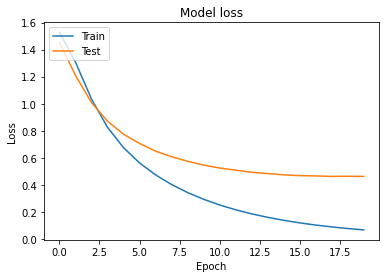

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()